# Introduction to Financial Engineering [IE471]
##  Hands-on Practice on Financial AI Session #1

### 1. Import Packages
#### Please import pandas_datareader package using 'pip install pandas_datareader'.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
plt.style.use('ggplot')

### 2. Loading the Dataset

In [2]:
start = (2000, 1, 1)  # 2000-01-01 
start_time = datetime.datetime(*start)  
end = (2020, 12, 31) # 2020-12-31
end_time = datetime.datetime(*end) 

# Loading Microsoft from Yahoo finance
df = pdr.DataReader('MSFT', 'yahoo', start_time, end_time)

High : HIgh Price, The highest price at which a stock traded during that particular day

Low : Low Price, The lowest price at which a stock traded during that particular day

Open : Open Price, The stock price at which opens at the start of market

Close : Close Price, The stock closing at the end of the market hours

Volume : Trading volume during that particular day

Adj Close : A stock's closing price to reflect that stock's value after accounting for any corporate actions (Reference: https://help.yahoo.com/kb/SLN28256.html)

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1999-12-31,58.8750,58.1250,58.75000,58.37500,12517600.0,37.076923
2000-01-03,59.3125,56.0000,58.68750,58.28125,53228400.0,37.017384
2000-01-04,58.5625,56.1250,56.78125,56.31250,54119000.0,35.766914
2000-01-05,58.1875,54.6875,55.56250,56.90625,64059600.0,36.144032
2000-01-06,56.9375,54.1875,56.09375,55.00000,54976600.0,34.933285


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,223.610001,221.199997,221.419998,222.750000,10550600.0,222.238144
2020-12-28,226.029999,223.020004,224.449997,224.960007,17933500.0,224.443069
2020-12-29,227.179993,223.580002,226.309998,224.149994,17403200.0,223.634918
2020-12-30,225.630005,221.470001,225.229996,221.679993,20272300.0,221.170593
2020-12-31,223.000000,219.679993,221.699997,222.419998,20942100.0,221.908905


In [5]:
X = df # Using high price, low price, Open price, Close price, Volume, and Adjusted Close Price to predict adjusted close price
y = df.iloc[:, 5:6] #Predicting adjusted close price

### 3. Scaling and Converting Data

We can see that there is a big difference between volume and other values. In this case, LSTM models need to recognize the difference between these two scales: volume and the rest values, which can be a burden to train data. Therefore, we reduce by scaling all variables from 0 to 1 to reduce the burden on the model.

In [6]:
MMS = MinMaxScaler()

X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

# Input Variables (6 variables)
X_train = X_data[:4780, :] #We trained 2000 - 2018 data including high price, low price, open price, close price, volume, and adj close data
X_test = X_data[4780:5273, :] #To verify trained model, we used 2019 - 2020 data as the test set

# Output Variables (adjusted close price)
y_train = y_data[1:4781, :]
y_test = y_data[4781:, :] 

print("Training Set Shape", X_train.shape, y_train.shape)
print("Testing Set Shape", X_test.shape, y_test.shape) 

Training Set Shape (4780, 6) (4780, 1)
Testing Set Shape (493, 6) (504, 1)


In [7]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4780, 1, 6]) torch.Size([4780, 1])
Testing Shape torch.Size([493, 1, 6]) torch.Size([504, 1])


In [8]:
device = torch.device('cpu')

### 4. Building LSTM Model

In [9]:
class LSTM_model(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM_model, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #LSTM layer
    self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer

  def forward(self,x):
    h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
    # Decode the hidden state of the last time step
    out = self.fc(out[:, -1, :])
    return out

### 5. Setting Hyperparameters and Training Data

In [10]:
num_epochs = 5000
learning_rate = 0.001

input_size = 6 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked LSTM layers

num_classes = 1 #number of output classes 
LSTM_1 = LSTM_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(LSTM_1.parameters(), lr=learning_rate)  # adam optimizer

In [11]:
for epoch in range(num_epochs+1):
    outputs = LSTM_1.forward(X_train_tensors_final.to(device)) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = loss_function(outputs, y_train_tensors.to(device))

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    
    if epoch % 100 == 0:
        print("Epoch: %d, Loss: %1.4f" % (epoch, loss.item())) 

Epoch: 0, Loss: 0.0090
Epoch: 100, Loss: 0.0052
Epoch: 200, Loss: 0.0010
Epoch: 300, Loss: 0.0002
Epoch: 400, Loss: 0.0001
Epoch: 500, Loss: 0.0001
Epoch: 600, Loss: 0.0001
Epoch: 700, Loss: 0.0001
Epoch: 800, Loss: 0.0001
Epoch: 900, Loss: 0.0001
Epoch: 1000, Loss: 0.0001
Epoch: 1100, Loss: 0.0001
Epoch: 1200, Loss: 0.0001
Epoch: 1300, Loss: 0.0001
Epoch: 1400, Loss: 0.0001
Epoch: 1500, Loss: 0.0001
Epoch: 1600, Loss: 0.0001
Epoch: 1700, Loss: 0.0001
Epoch: 1800, Loss: 0.0001
Epoch: 1900, Loss: 0.0000
Epoch: 2000, Loss: 0.0000
Epoch: 2100, Loss: 0.0000
Epoch: 2200, Loss: 0.0000
Epoch: 2300, Loss: 0.0000
Epoch: 2400, Loss: 0.0000
Epoch: 2500, Loss: 0.0000
Epoch: 2600, Loss: 0.0000
Epoch: 2700, Loss: 0.0000
Epoch: 2800, Loss: 0.0000
Epoch: 2900, Loss: 0.0000
Epoch: 3000, Loss: 0.0000
Epoch: 3100, Loss: 0.0000
Epoch: 3200, Loss: 0.0000
Epoch: 3300, Loss: 0.0000
Epoch: 3400, Loss: 0.0000
Epoch: 3500, Loss: 0.0000
Epoch: 3600, Loss: 0.0000
Epoch: 3700, Loss: 0.0000
Epoch: 3800, Loss: 0.000

In [12]:
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 20})

### 6. Results

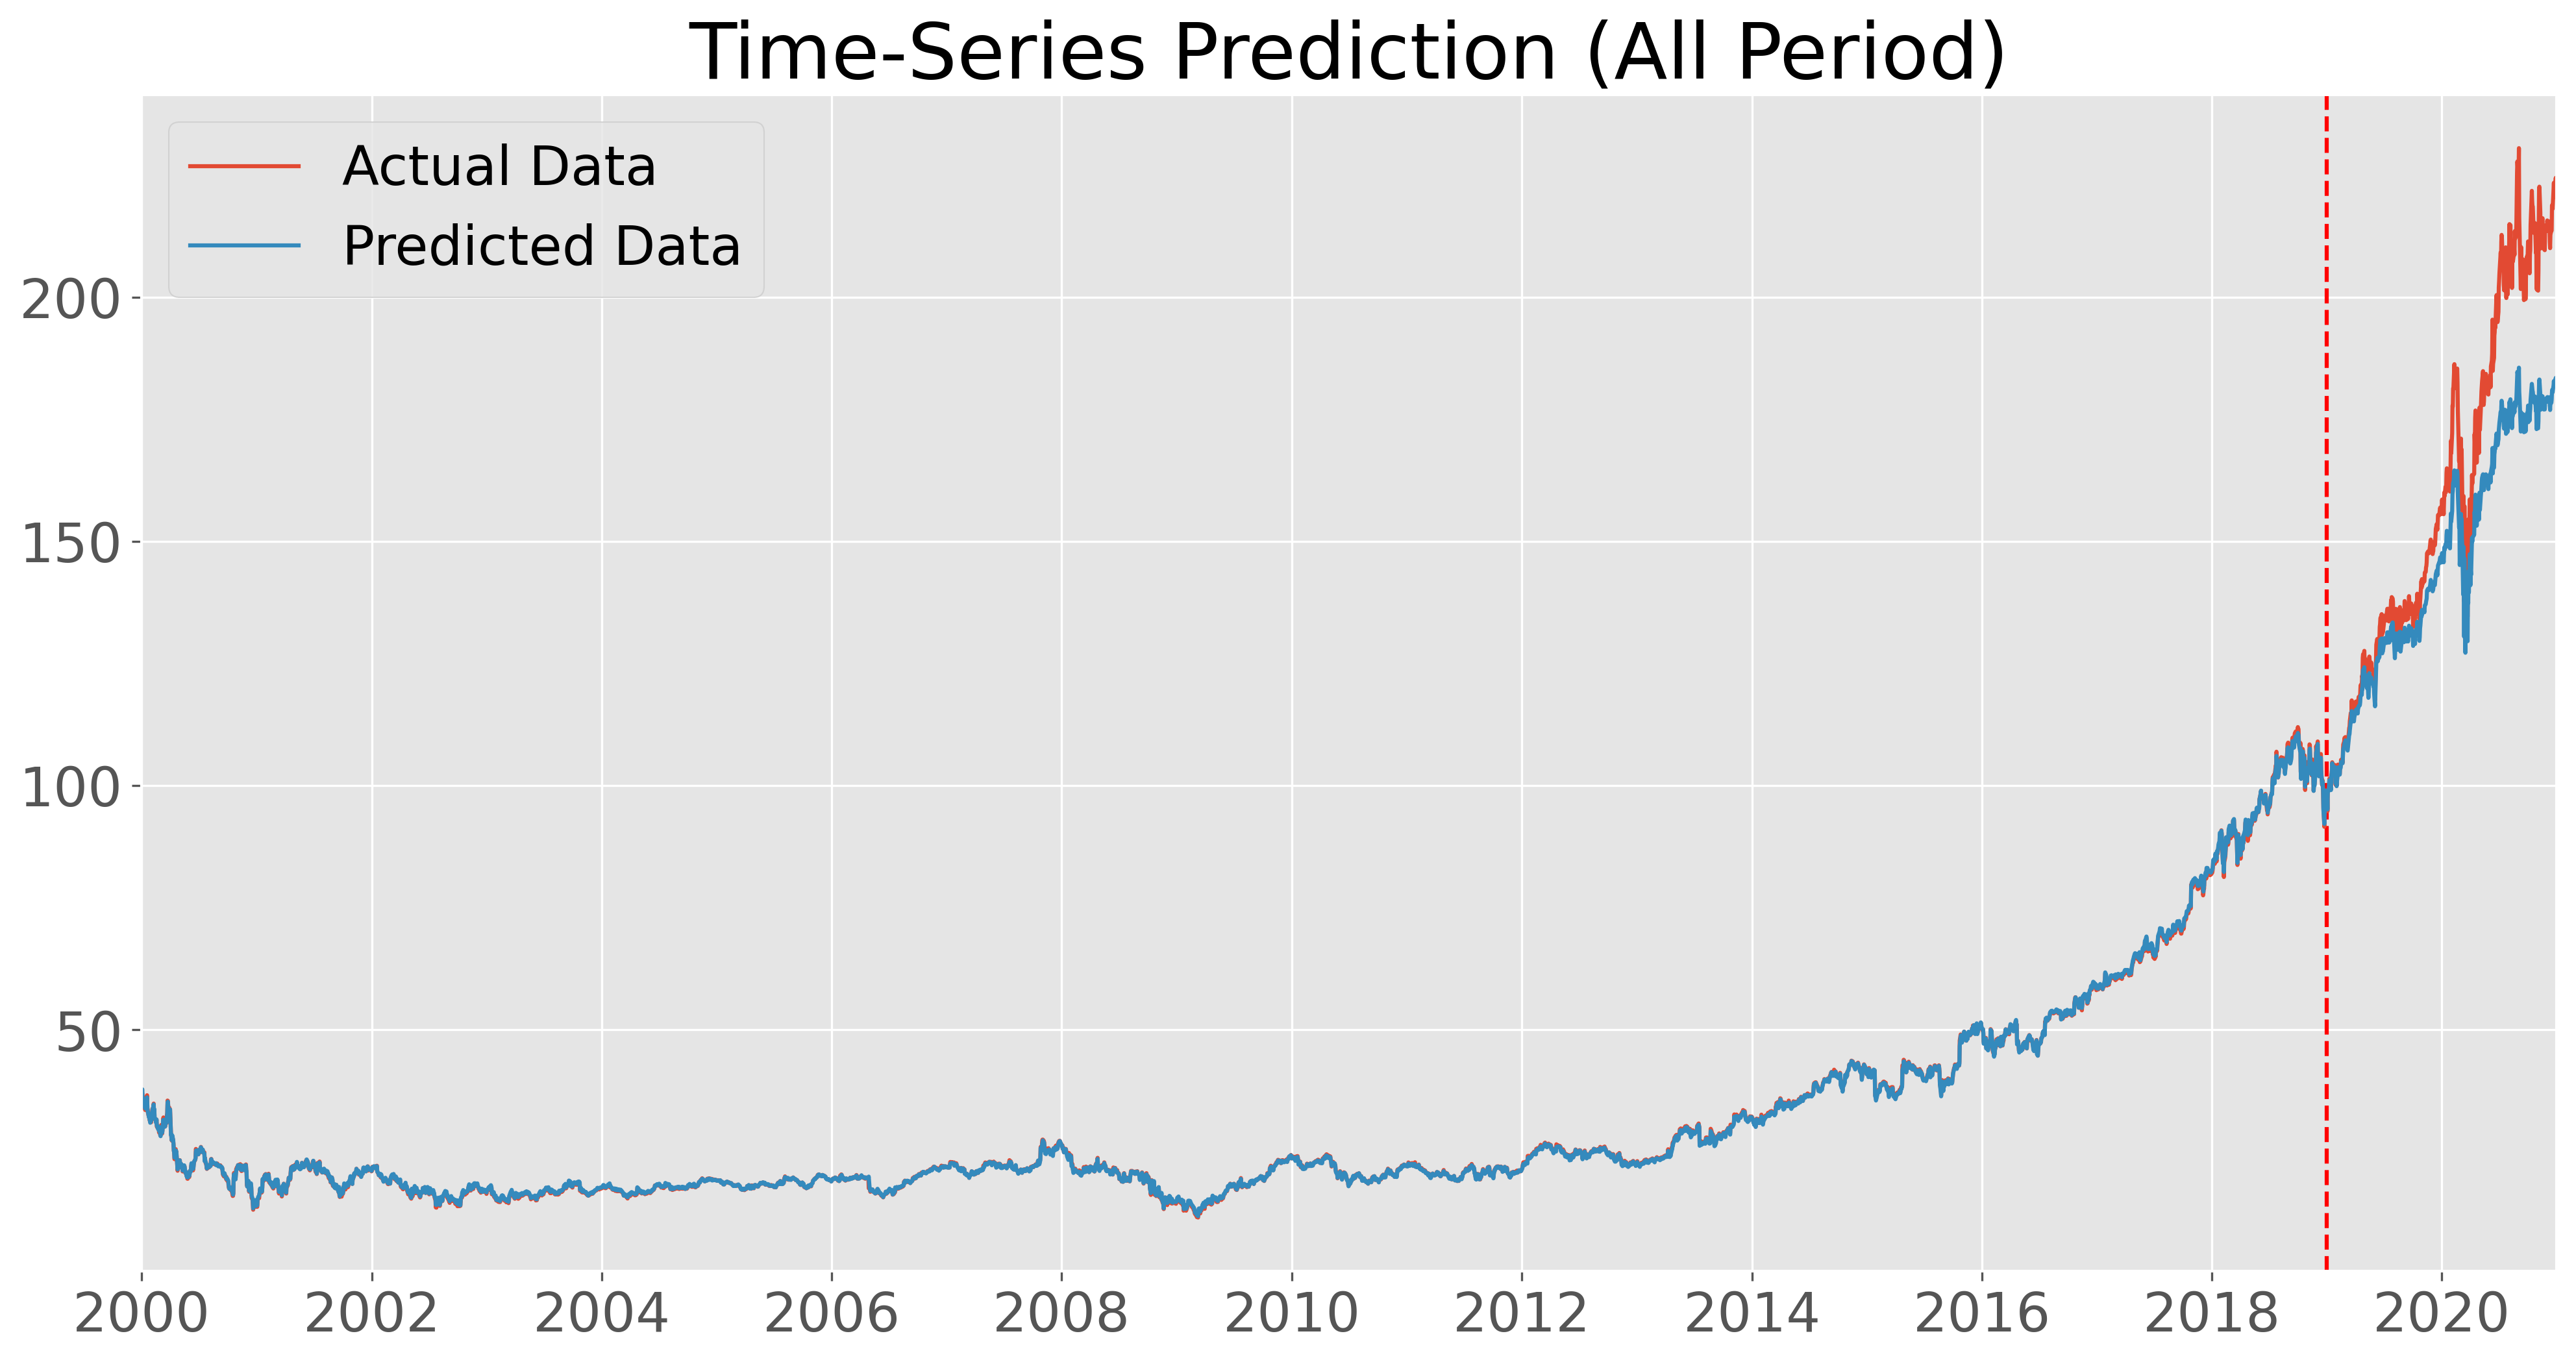

In [20]:
X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

df_X = Variable(torch.Tensor(X_data)) #converting to Tensors
df_y = Variable(torch.Tensor(y_data))
#reshaping the dataset
df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
train_predict = LSTM_1(df_X.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y.data.numpy()

data_predict = MMS.inverse_transform(data_predict) #reverse transformation
dataY_plot = MMS.inverse_transform(dataY_plot)

plt.xlim(datetime.datetime(2000, 1, 1), datetime.datetime(2020, 12, 31))
test_line = datetime.datetime(2019, 1, 1)
plt.axvline(x=test_line, c='r', linestyle='--') #size of the training set

plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (All Period)')
plt.legend()
plt.savefig('images/prediction_base_all_microsoft.pdf', bbox_inches='tight')
plt.show() 

In [14]:
MSE = float(sum((dataY_plot - data_predict)*(dataY_plot - data_predict))/len(data_predict))
print('Mean Squared Error:', MSE)

Mean Squared Error: 35.924259185791016


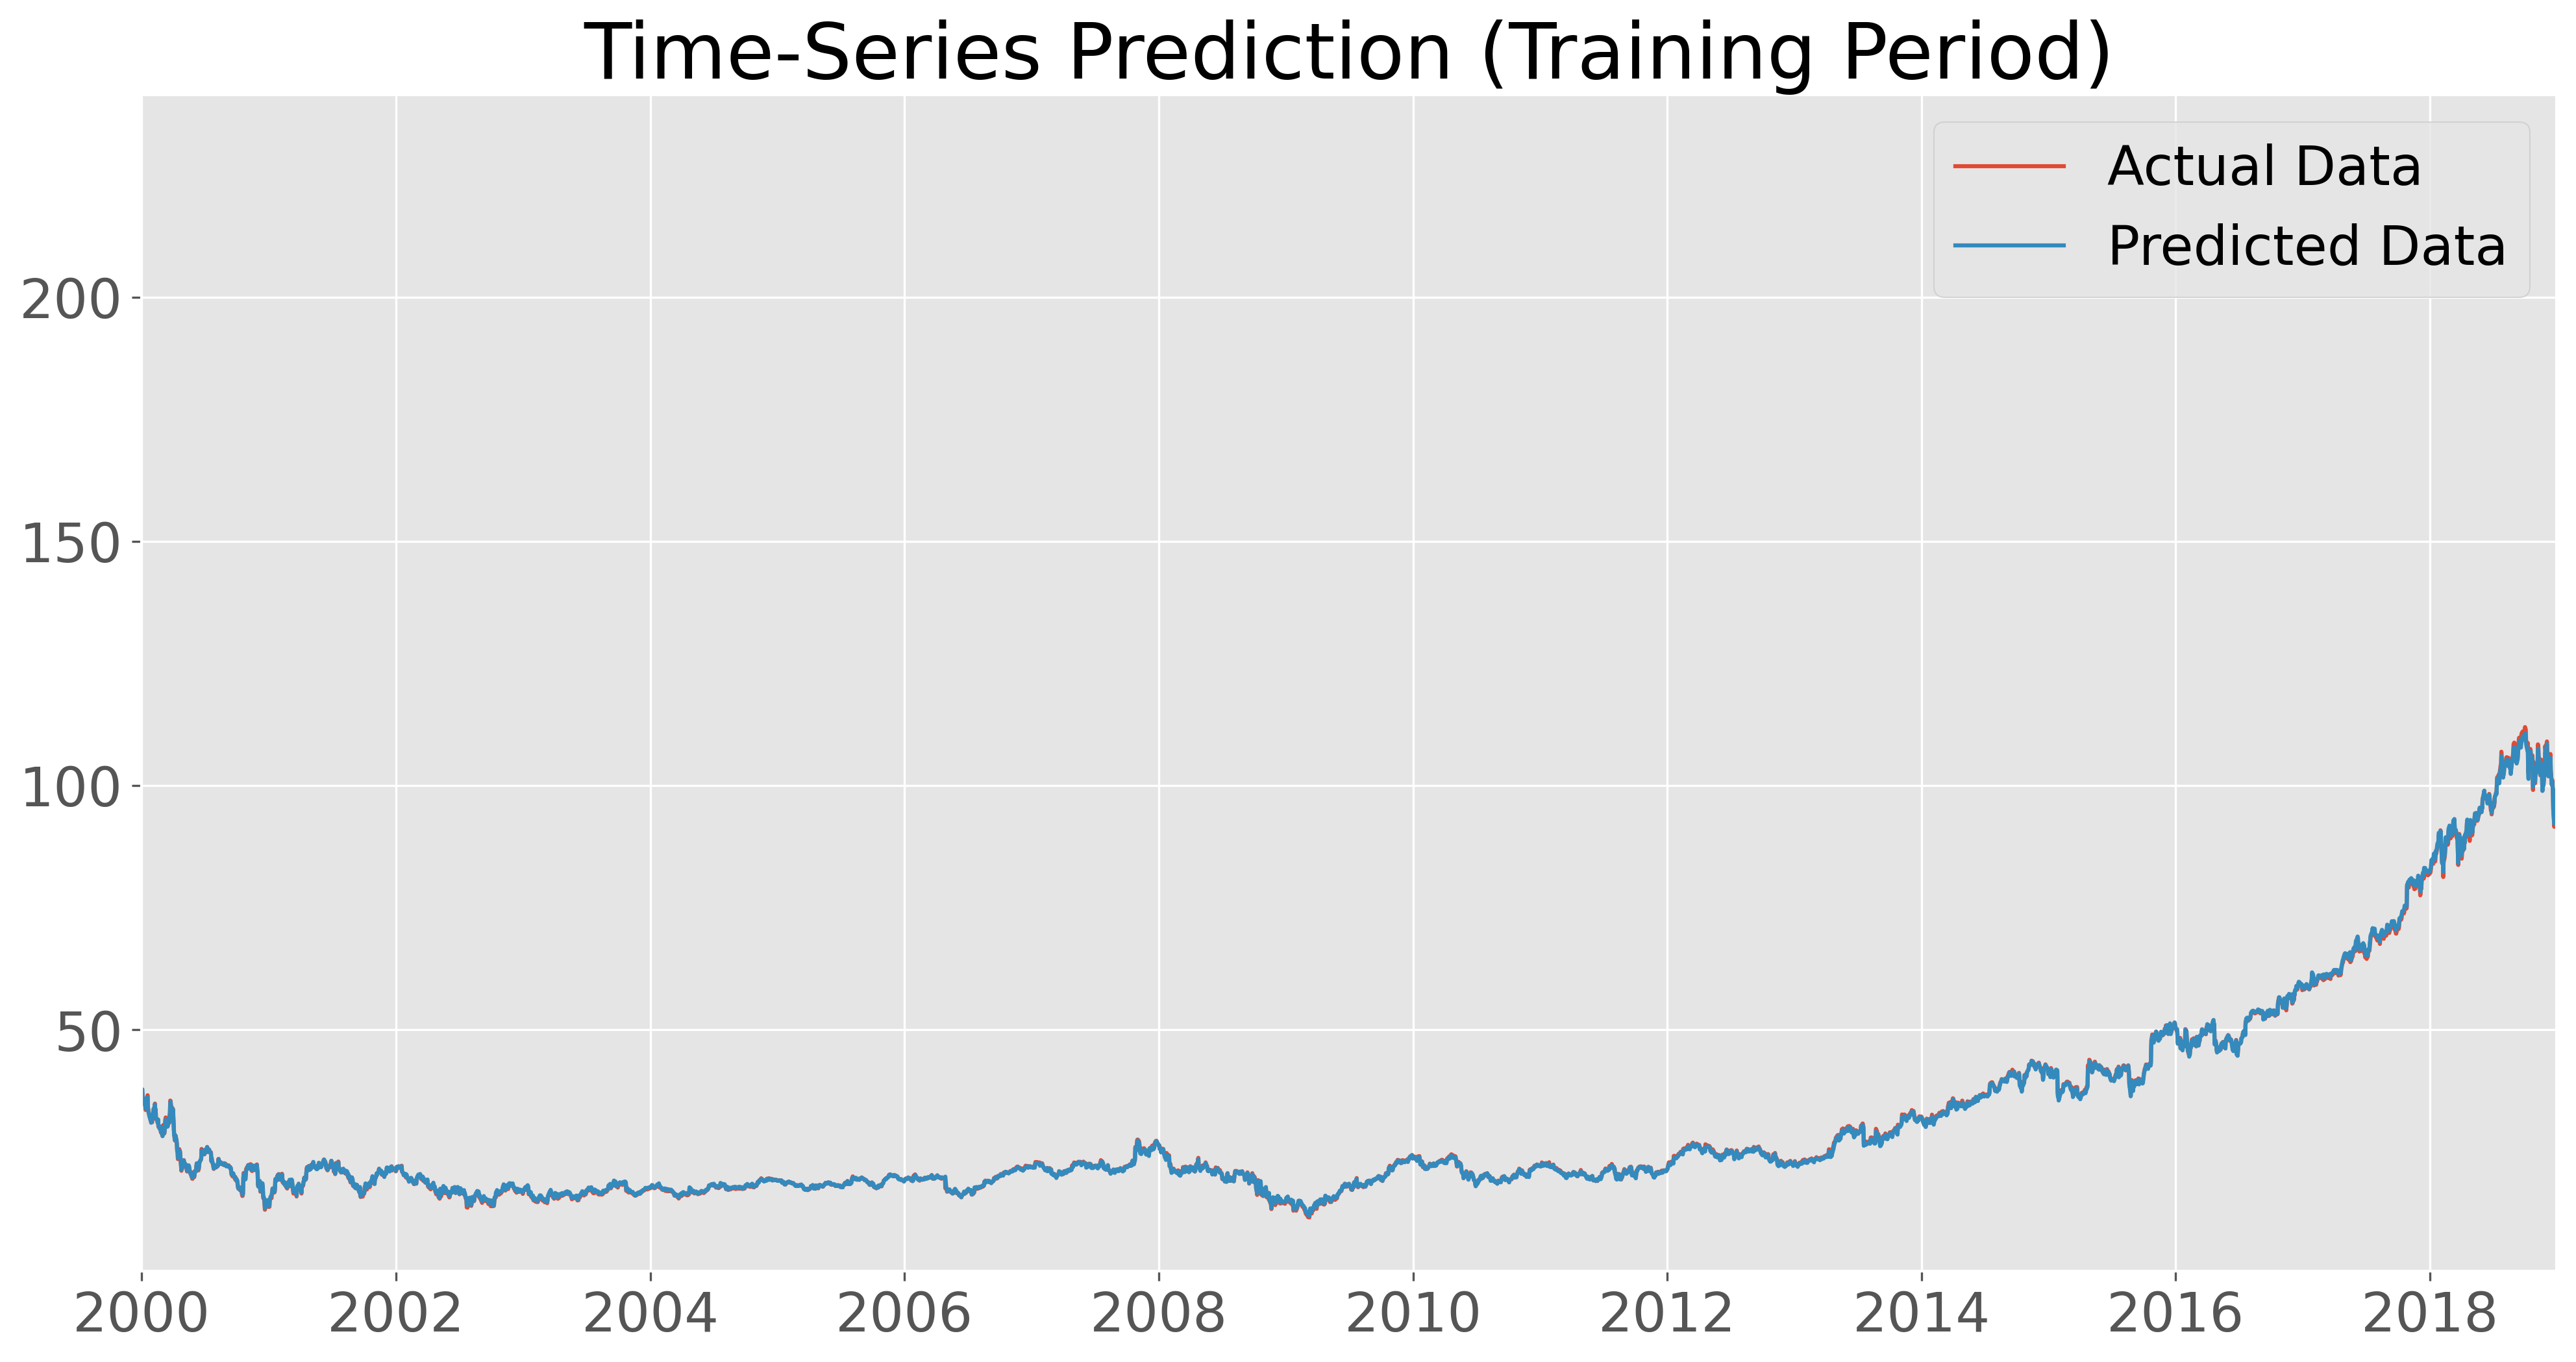

In [21]:

plt.xlim(datetime.datetime(2000, 1, 1), datetime.datetime(2018, 12, 31))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (Training Period)')
plt.legend()
plt.savefig('images/prediction_base_train_microsoft.pdf', bbox_inches='tight')
plt.show() 

In [16]:
MSE_train = float(sum((dataY_plot[0:4780] - data_predict[0:4780])*(dataY_plot[0:4780] - data_predict[0:4780]))/len(data_predict[0:4780]))
print('Mean Squared Error (Training Data):', MSE_train)

Mean Squared Error (Training Data): 0.05674871429800987


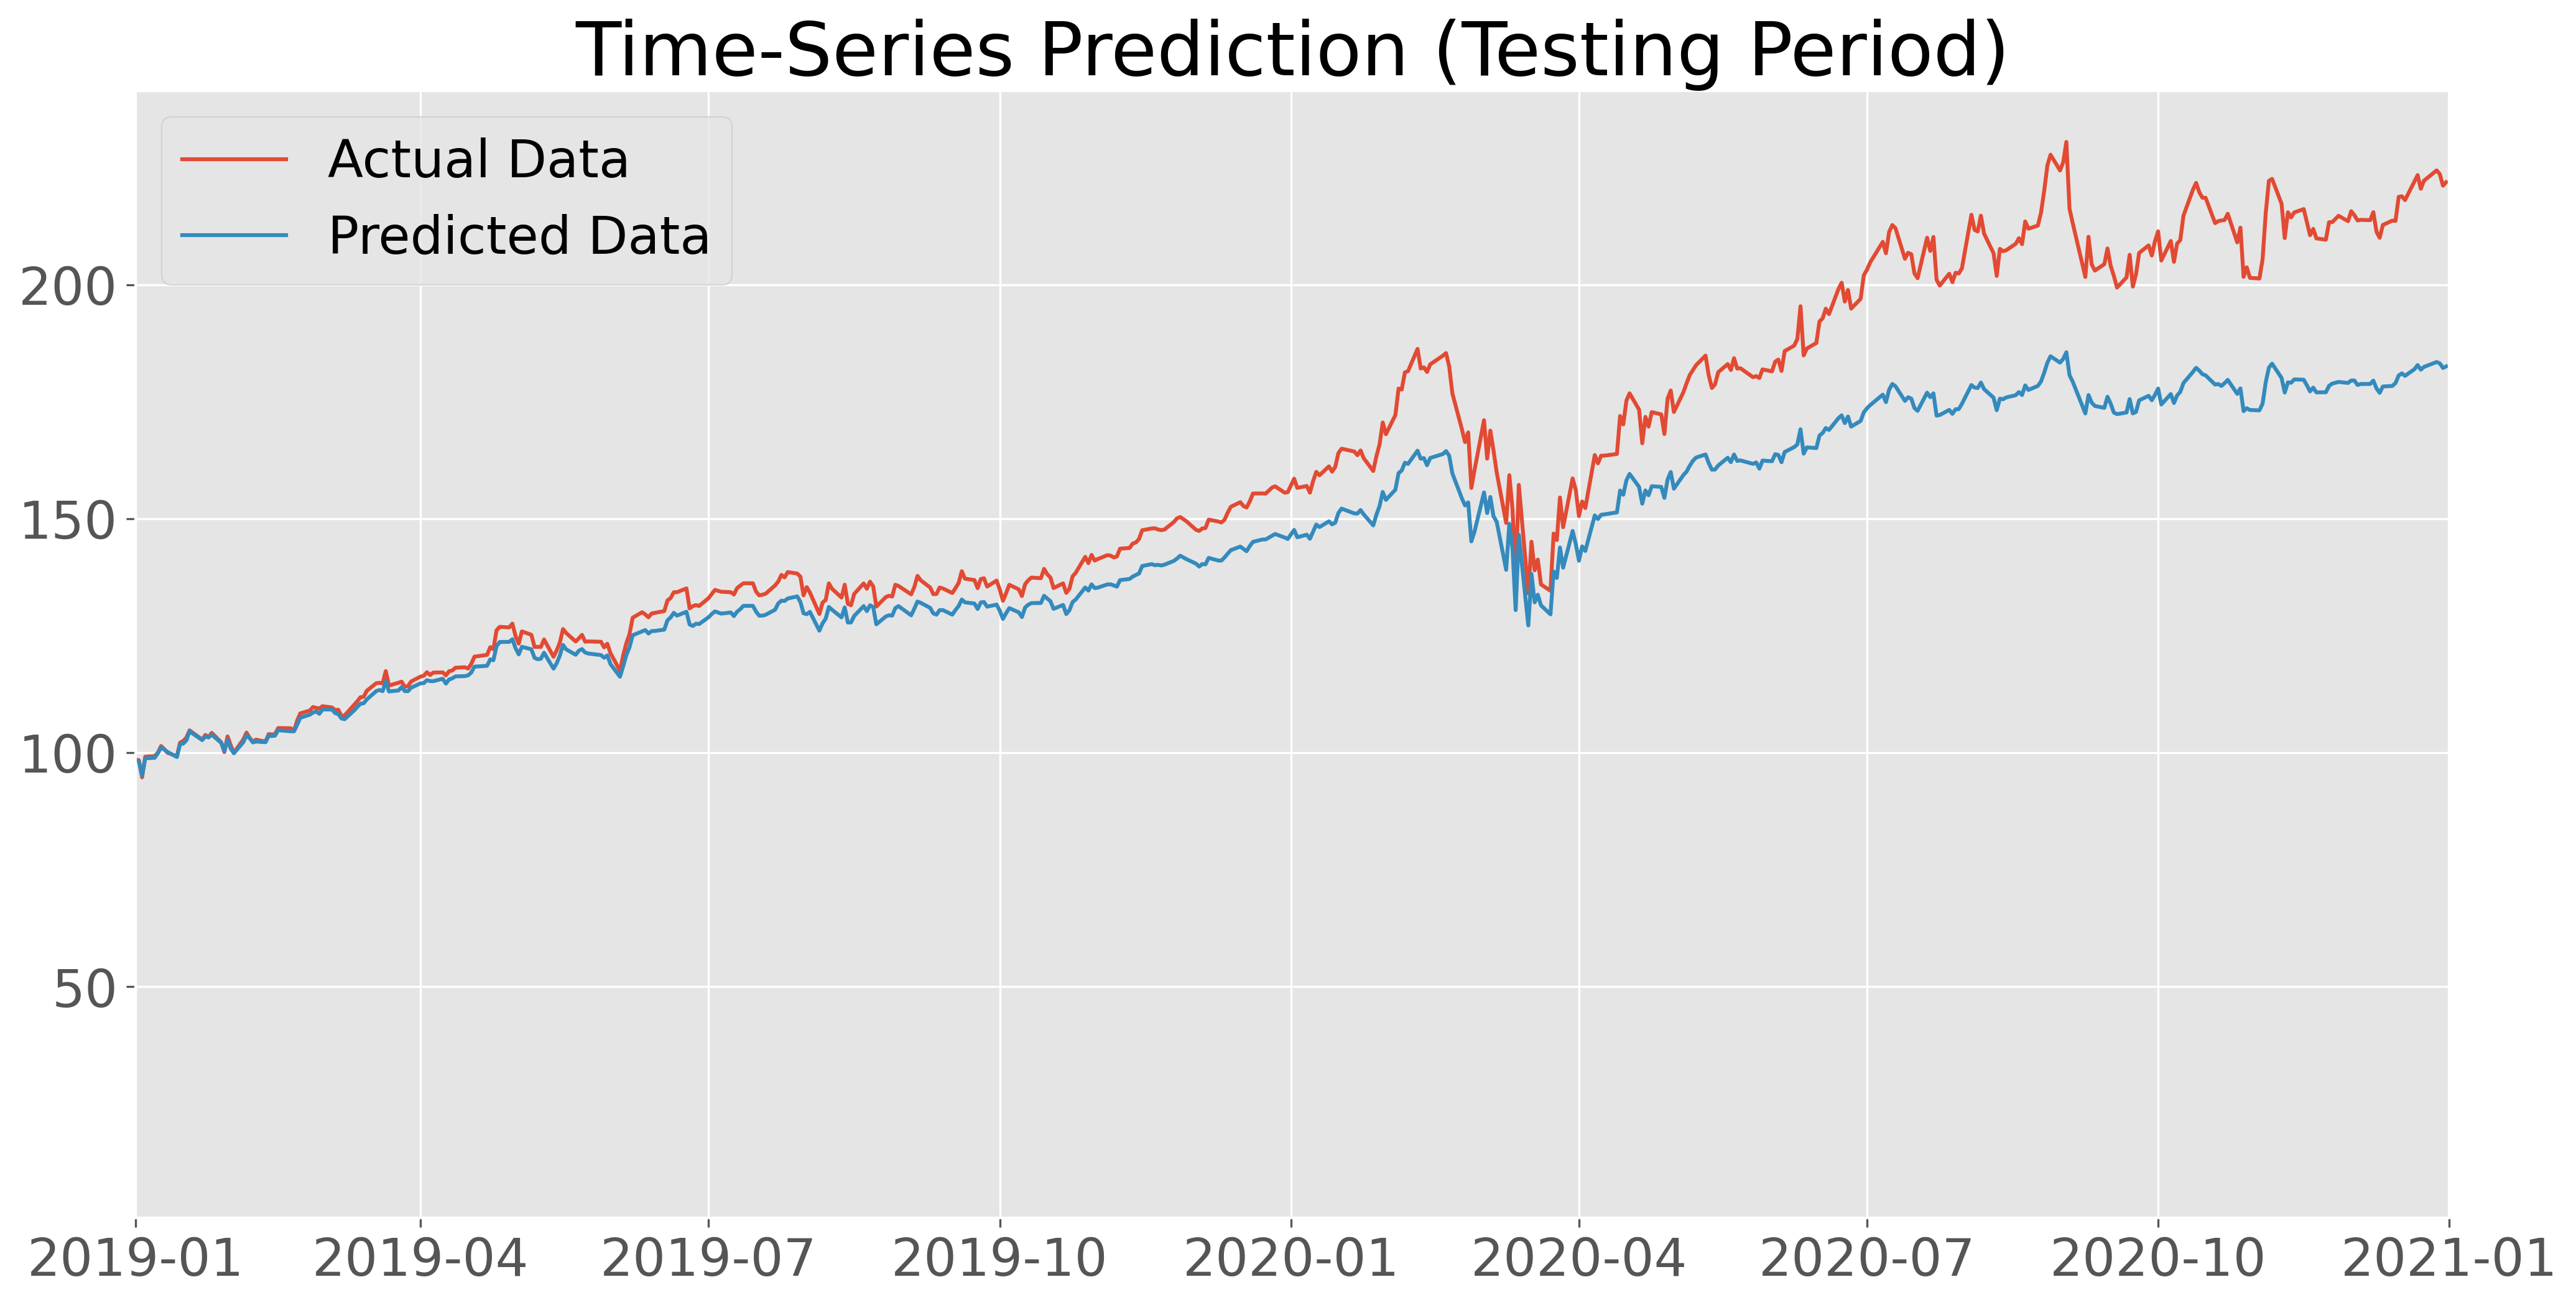

In [22]:
plt.xlim(datetime.datetime(2019, 1, 1), datetime.datetime(2021, 1, 1))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (Testing Period)')
plt.legend()
plt.savefig('images/prediction_base_test_microsoft.pdf', bbox_inches='tight')
plt.show()

In [18]:
MSE_test = float(sum((dataY_plot[4780:] - data_predict[4780:])*(dataY_plot[4780:] - data_predict[4780:]))/len(data_predict[4780:]))
print('Mean Squared Error (Test Data):', MSE_test)

Mean Squared Error (Test Data): 375.4226989746094


## Mean Squared Error of Training and Test Data

In [19]:
MSE = float(sum((dataY_plot - data_predict)**2)/len(data_predict))
print('Mean Squared Error (Training and test):', MSE)

Mean Squared Error (Training and test): 35.924259185791016
